# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Fiqih Hidayaturrahman
- Email: fiqihhidayaturrahman@gmail.com
- Id Dicoding: fiqih hidayaturrahman

Menganalisis faktor-faktor yang memengaruhi attrition (turnover) karyawan dan membuat visualisasi interaktif menggunakan Metabase.

## Persiapan

### Menyiapkan library yang dibutuhkan

In [33]:
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Menyiapkan data yang akan diguankan

In [6]:
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv", encoding='windows-1252')

### Unggah Dataset ke Database

Unggah dataset ke database supabase untuk digunakan sebagai visualisasi pada Metabase

In [ ]:
URL = "URL"

engine = create_engine(URL)
df.to_sql('Employee', engine)

562

## Data Understanding

In [7]:
df.head(5)

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


In [8]:
# Tampilkan semua kolom
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Ukuran dataset
print("\nUkuran dataset:")
print(df.shape)

# Info umum dataset
print("\nInfo dataset:")
print(df.info())

# Statistik deskriptif
print("\nStatistik deskriptif:")
print(df.describe(include='all'))

# Cek missing values
print("\nJumlah missing values per kolom:")
print(df.isnull().sum())


Ukuran dataset:
(1470, 35)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement      

### Analisis Awal: Ringkasan Temuan
**Ukuran Data**
1. Dataset berisi 1470 baris dan 35 kolom.
2. Tipe data: Terdiri dari kombinasi fitur numerik (int64, float64) dan kategorikal (object).

**Masalah Data**
1. Kolom target: **Attrition** (bernilai 0.0, 1.0, dan banyak NaN – ada 412 missing values).
2. **EmployeeCount**, **StandardHours**, dan **Over18** tidak memiliki variasi (semua nilainya sama). Kolom ini kemungkinan tidak informatif untuk model prediktif.

**Statistik Umum**
1. Usia karyawan: Rata-rata 36,9 tahun, rentang 18–60.
2. Rata-rata MonthlyIncome: 6.503. Min-Max: 1.009 – 19.999 (distribusi kemungkinan skewed).
3. Rata-rata 7 tahun di perusahaan dan 11 tahun total pengalaman kerja.
4. Skor rata-rata **Work-Life Balance**: 2.76 (dari skala 1–4) → indikasi sedang hingga baik.
5. **Job Satisfaction** dan **Environment Satisfaction**: Kedua skor sekitar 2.7 dari 4, cukup moderat.
6. **OverTime**: 1054 karyawan tidak lembur. potensi fitur penting jika dihubungkan dengan attrition.
7. **BusinessTravel**: mayoritas Travel_Rarely (1.043 dari 1.470).

**Kemungkinan Fitur Penting**
1. JobRole (9 kategori)
2. MaritalStatus
3. OverTime
4. Department
5. BusinessTravel

**Target Variabel: Attrition**
1. Dikelompokan menjadi 1.0 (pernah resign) dan 0.0 (tidak resign).
2. 28% datanya missing, harus dibersihkan atau diproses lebih lanjut.
3. Distribusi target (sementara dari data valid): sekitar 16,9% yang resign. Dataset tidak seimbang, penting untuk diperhatikan dalam modeling.

**Langkah Selanjutnya**
1. Menangani missing values di **Attrition**
2. Drop kolom yang tidak variatif: **EmployeeCount**, **StandardHours**, **Over18**.
3. Encoding pada kolom kategorikal.
4. Eksplorasi visualisasi untuk menemukan korelasi awal antara fitur dan attrition.
5. Analisis distribusi dari MonthlyIncome, YearsAtCompany, dan fitur numerik lain.



## Pembersihan Data

**Drop kolom redundan / konstan**
Beberapa kolom yang tidak informatif untuk analisis atau model prediksi:
1. **EmployeeId:** ID unik, tidak relevan.
2. **EmployeeCount:** Hanya berisi nilai 1, tidak berguna.
3. **Over18:** Hanya berisi 'Y', tidak berguna.
4. **StandardHours:** Semua 80 , tidak berguna.

In [ ]:
# Drop kolom tidak variatif dan ID
df_clean = df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeId'])

**Penanganan Missing Value:**
1. Kolom **Attrition** berisi 412 nilai NaN dari 1470 baris, sekitar 28%. Ini signifikan dan harus ditangani dengan hati-hati.
2. Memisahkan baris dengan nilai 'NaN' ke dataset test/prediksi (**data_unlabeled**).

In [10]:
# Pisahkan data dengan label dan tanpa label
data_labeled = df_clean[df_clean['Attrition'].notnull()].copy() # untuk train
data_unlabeled = df_clean[df_clean['Attrition'].isnull()].copy() # untuk inference

**Simpan Data Unlabeled**

Data Unlabeled (tidak memiliki label 'Attrition' disimpan untuk digunakan pada inference model)

In [37]:
data_unlabeled = data_unlabeled.drop(columns=['Attrition'])
data_unlabeled.to_csv("unlabeled_data.csv", index=False)

**Cek ulang setelah proses pembersihan data** 

Karena Missing value hanya terdapat pada fitur **Attrition**, maka seluruh data dengan nilai **Attrition** yang hilang akan disimpan kedalam data_unlabeled untuk dipakai saat inference.

In [14]:
# Cek missing value setelah dibersihkan
print("\nJumlah missing values data labeled untuk train:")
print(data_labeled.isnull().sum())

print("\nJumlah missing values data unlabeled untuk inference:")
print(data_unlabeled.isnull().sum())

# Cek dimensi akhir
print("\nUkuran dataset labeled untuk train:")
print(data_labeled.shape)

print("\nUkuran dataset unlabeled untuk inference:")
print(data_unlabeled.shape)


Jumlah missing values data labeled untuk train:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Jumlah 

## Exploratory Data Analysis


### Rangkuman Parameter Statistik

In [15]:
df_clean.describe(include="all")

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1058.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,NaN,3,NaN,3,NaN,NaN,6,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1043,NaN,961,NaN,NaN,606,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,0.169187,NaN,802.485714,NaN,9.192517,2.912925,NaN,2.721769,NaN,65.891156,2.729932,2.063946,NaN,2.728571,NaN,6502.931293,14313.103401,2.693197,NaN,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,0.375094,NaN,403.509100,NaN,8.106864,1.024165,NaN,1.093082,NaN,20.329428,0.711561,1.106940,NaN,1.102846,NaN,4707.956783,7117.786044,2.498009,NaN,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,0.000000,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,NaN,465.000000,NaN,2.000000,2.000000,NaN,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2911.000000,8047.000000,1.000000,NaN,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,NaN,802.000000,NaN,7.000000,3.000000,NaN,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4919.000000,14235.500000,2.000000,NaN,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,NaN,1157.000000,NaN,14.000000,4.000000,NaN,4.000000,NaN,83.750000,3.000000,3.000000,NaN,4.000000,NaN,8379.000000,20461.500000,4.000000,NaN,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


**Insight**
- Belum ada insight yang menarik dari hasil rangkuman parameter statistik. 

### Cek Distirbusi nilai **Attrition** 

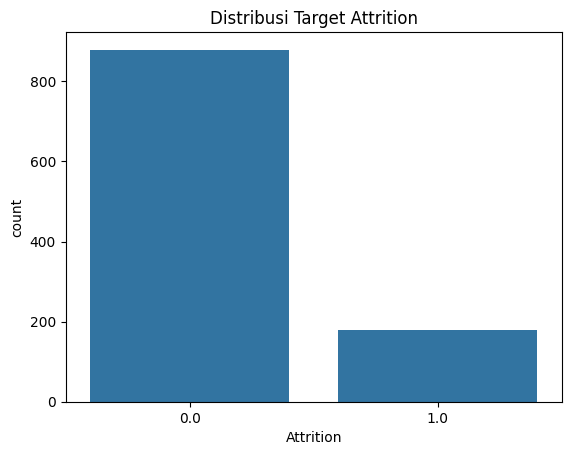

Attrition
0.0    0.830813
1.0    0.169187
Name: proportion, dtype: float64


In [16]:
sns.countplot(data=data_labeled, x='Attrition')
plt.title('Distribusi Target Attrition')
plt.show()

print(data_labeled['Attrition'].value_counts(normalize=True))

**Insight**
- Label pada data **Attrition** memiliki jumlah yang tidak seimbang. Kelas 1.0 hanya memiliki nilai sekitar 17%
- Nilai Label yang tidak seimbang ini bisa menyebabkan bias ke mayoritas (non-attrition), sehingga bisa menghasilkan akurasi tinggi namun F1-score atau recall untuk kelas minoritas bisa buruk.

### Korelasi Kolom Numerik dengan Target (Attrition)

In [17]:
df_clean['Attrition'] = df_clean['Attrition'].map({1.0: 1, 0.0: 0})
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Attrition')

# Korelasi numerik dengan target
correlations = df_clean[numerical_cols + ['Attrition']].corr()
attr_corr = correlations['Attrition'].drop('Attrition').sort_values(key=abs, ascending=False)

print("Korelasi Fitur Numerik dengan Attrition:")
print(attr_corr)

Korelasi Fitur Numerik dengan Attrition:
TotalWorkingYears          -0.177137
Age                        -0.172067
JobLevel                   -0.169201
StockOptionLevel           -0.164228
MonthlyIncome              -0.163600
YearsInCurrentRole         -0.158757
YearsWithCurrManager       -0.155962
JobInvolvement             -0.150196
YearsAtCompany             -0.135134
EnvironmentSatisfaction    -0.132848
JobSatisfaction            -0.091751
DistanceFromHome            0.078074
WorkLifeBalance            -0.059556
RelationshipSatisfaction   -0.053417
DailyRate                  -0.051992
TrainingTimesLastYear      -0.047859
NumCompaniesWorked          0.037429
Education                  -0.032631
YearsSinceLastPromotion    -0.031944
MonthlyRate                 0.023299
HourlyRate                 -0.017524
PerformanceRating           0.007755
PercentSalaryHike           0.004907
Name: Attrition, dtype: float64


**Insight**
- Hasil korelasi fitur numerik dengan target (attrition) menunjukan seluruh fitur numerik memiliki korelasi dengan nilai beragam.
- fitur (TotalWorkingYears, Age, JobLevel, StockOptionLevel, MonthlyIncome) memiliki tingkat korelasi paling besar (negatif).

### Melihat Distribusi Fitur Numerik berdasarkan Attrition menggunakan Histogram

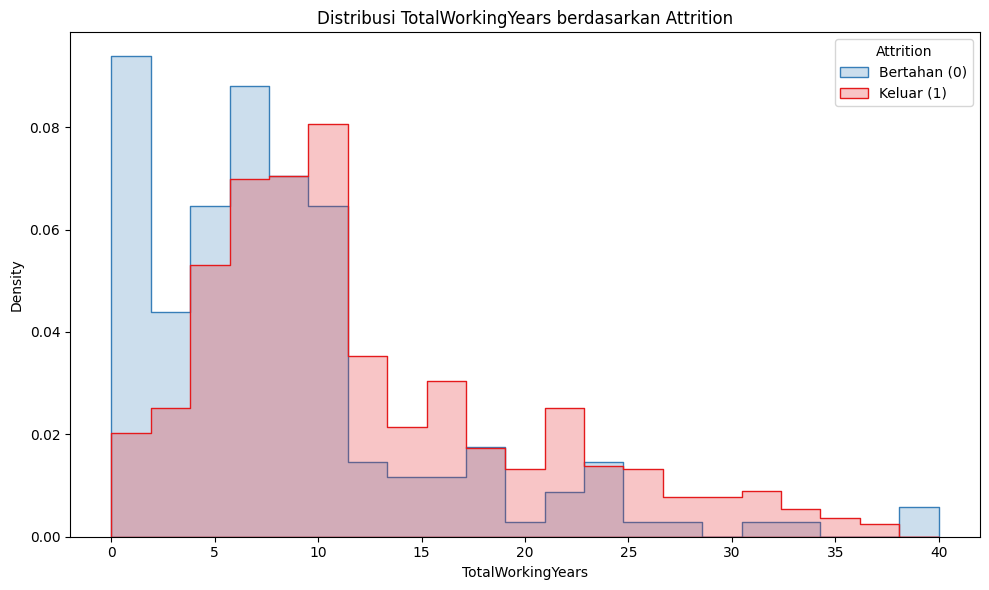

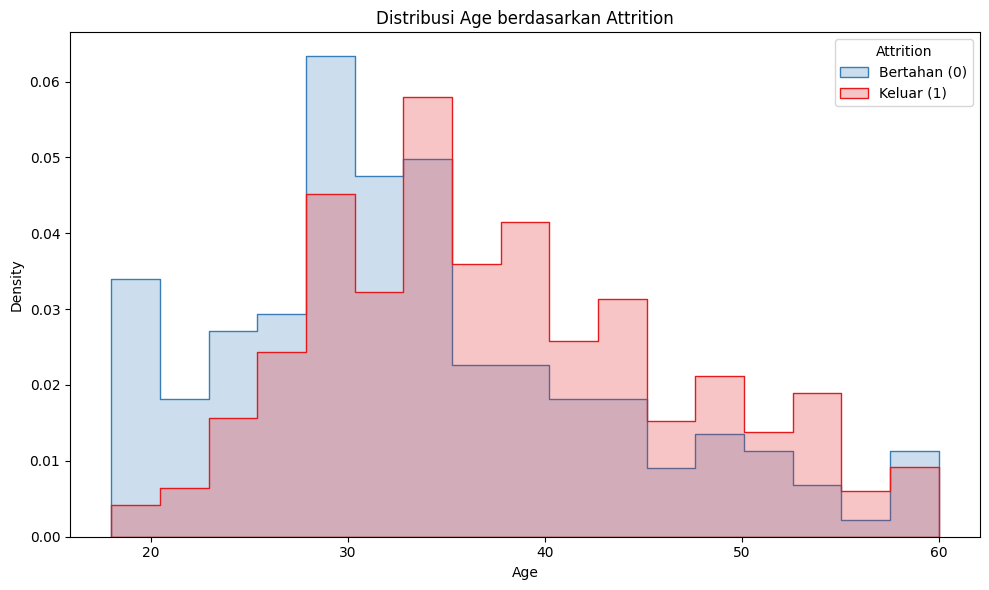

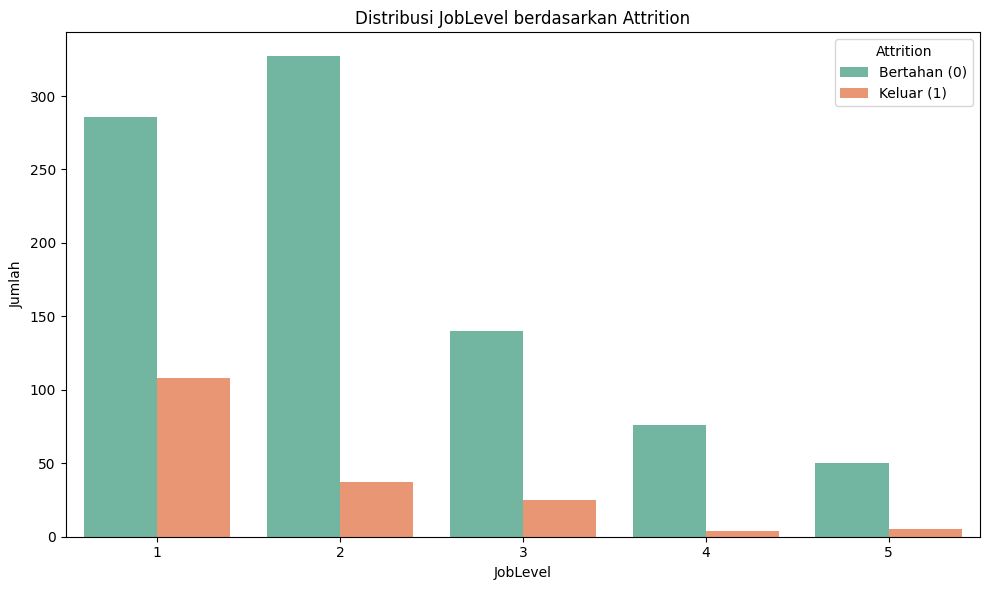

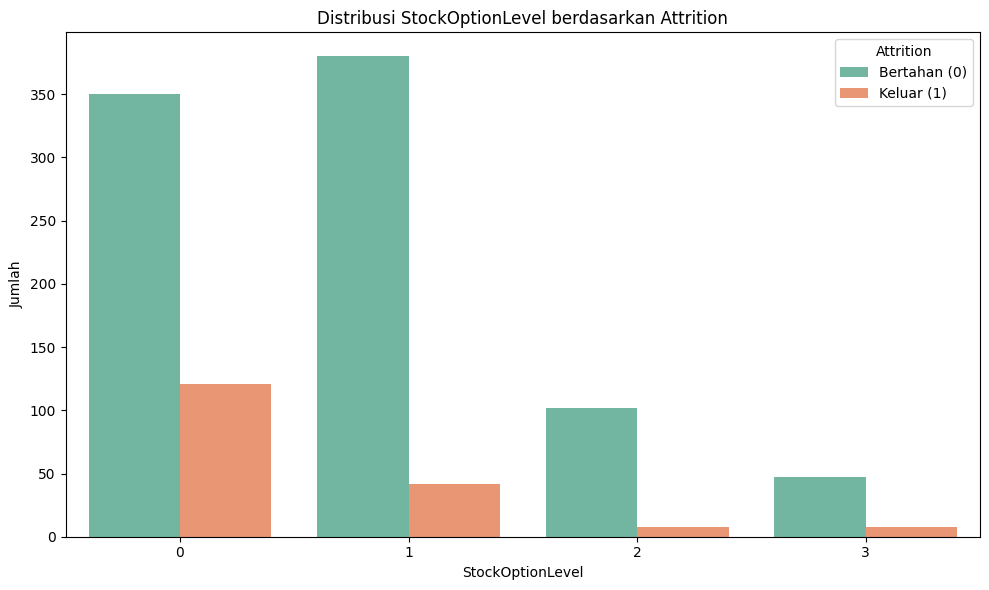

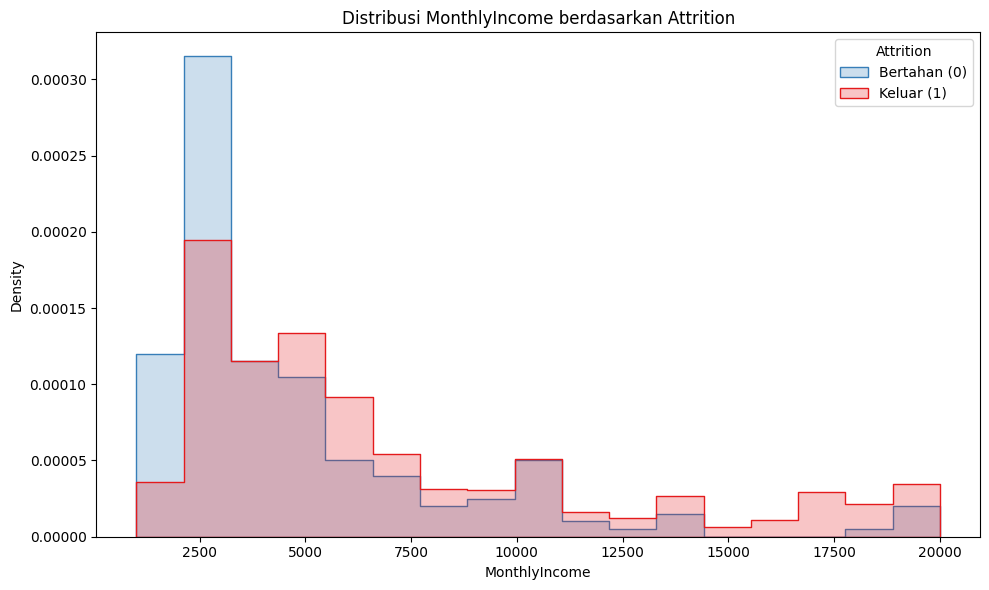

In [18]:
features = ['TotalWorkingYears', 'Age', 'JobLevel', 'StockOptionLevel', 'MonthlyIncome']

plt.rcParams["figure.figsize"] = (10, 6)

# Loop visualisasi
for feature in features:
    plt.figure()
    
    # Plot sesuai tipe data
    if df_clean[feature].nunique() <= 10:
        # Untuk fitur diskret (categorical numeric), gunakan countplot
        sns.countplot(data=df_clean, x=feature, hue="Attrition", palette="Set2")
        plt.title(f"Distribusi {feature} berdasarkan Attrition")
        plt.ylabel("Jumlah")
    else:
        # Untuk fitur kontinu, gunakan histogram KDE
        sns.histplot(
            data=df_clean, x=feature, hue="Attrition",
            palette="Set1", element="step", stat="density", common_norm=False
        )
        plt.title(f"Distribusi {feature} berdasarkan Attrition")
        plt.ylabel("Density")
    
    plt.xlabel(feature)
    plt.legend(title='Attrition', labels=['Bertahan (0)', 'Keluar (1)'])
    plt.tight_layout()
    plt.show()

**Insight**
- **TotalWorkingYears** memiliki tingkat **Attrition** "keluar" besar pada karyawan dengan masa kerja lebih dari 4 tahun.
- **Age** menunjukan kebanyakan karyawan yang "keluar" adalah karyawan dengan umur diatas 25 Tahun.
- Karayawan dengan **jobLevel** yang rendah (1) memiliki perbandingan **Attrition** yang besar.
- Karayawan dengan **StockOptionLevel** yang rendah (0) memiliki perbandingan **Attrition** yang besar.
- Pada **MonthlyIncome** terdapat insight yang unik. karyawan dengan gaji diatas 2500 memiliki tingkat "Attrition" (keluar) yang besar.

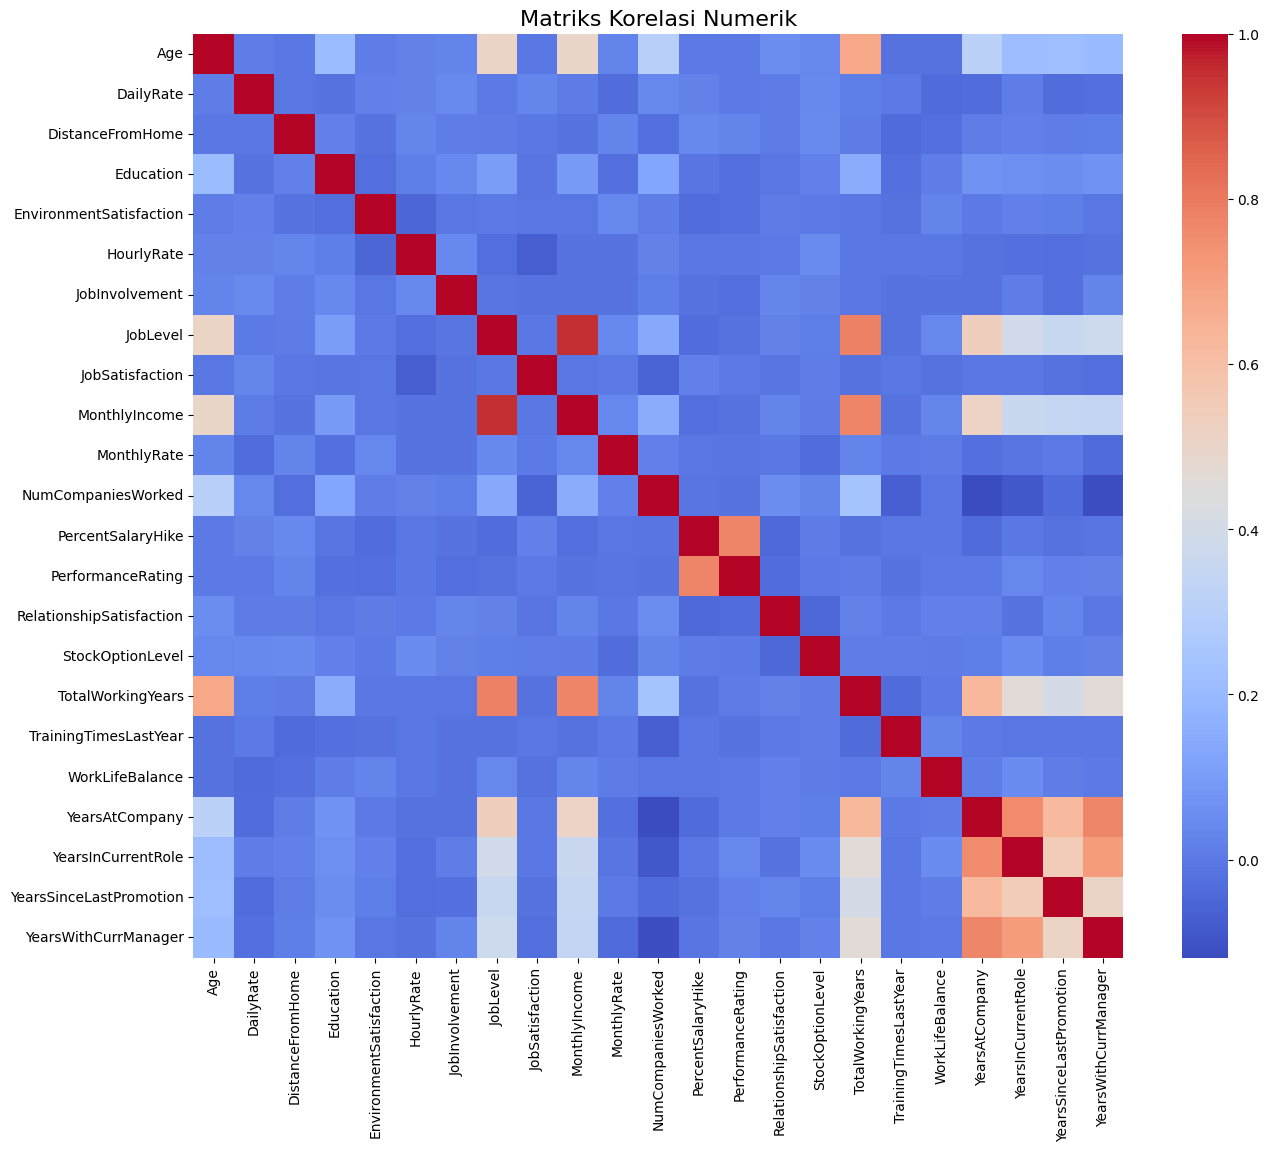

In [19]:
# Korelasi fitur numerik
plt.figure(figsize=(15,12))
corr = df_clean[numerical_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Matriks Korelasi Numerik", fontsize=16)
plt.show()

**Insight**
- **JobLevel** dan **MonthlyIncome** memiliki korelasi psotof yang sangat besar.

## Data Preparation / Preprocessing

### Pisahkan Fitur dan Target
pisahkan fitur/kolom (y) dari target **Attrition** (x)

In [20]:
X = data_labeled.drop(columns=['Attrition'])
y = data_labeled['Attrition'].map({1.0: 1, 0.0: 0})

### Split Data Menjadi Training dan Testing
Memisahkan data data_labeled menjadi data training dan testing untuk melatih model pada data training dan kemudian melakukan evaluasi pada data test yang tidak pernah dilihat sebelumnya oleh model.

In [21]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Identifikasi Tipe Data
pisahkan fitur/kolom kategorikal dan numerikal

In [22]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

### Pipeline Preprocessing
Menggunakan **ColumnTransformer** dari **sklearn** untuk encoding dan scaling:

In [23]:
# Pipeline untuk masing-masing tipe data
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

## Modeling

Pada tahap modelling, digunakan:
1. StratifiedKFold (CV 5-fold) cross-validation untuk evaluasi dan seluruh proses tuning & evaluasi dilakukan dalam skema CV. Menggantikan kebutuhan split manual train/val/test dan digunakan untuk mengukur performa model secara menyeluruh.
2. Model tuning menggunakan RandomizedSearchCV. Mencari kombinasi hyperparameter terbaik berdasarkan skor F1. CV dilakukan secara internal, jadi pembagian data tambahan tidak diperlukan.

### Random Forest + SMOTE

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\nFold {fold+1}")
    
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # Preprocessing manual (tanpa pipeline)
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    
    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train)
    
    # Model training
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_val_prep)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(classification_report(y_val, y_pred))
    acc_scores.append(acc)
    f1_scores.append(f1)
    
print("\nRata-rata CV Accuracy:", np.mean(acc_scores))
print("Rata-rata CV F1-score:", np.mean(f1_scores))


Fold 1
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       141
           1       0.64      0.31      0.42        29

    accuracy                           0.85       170
   macro avg       0.76      0.64      0.67       170
weighted avg       0.83      0.85      0.83       170


Fold 2
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       141
           1       0.56      0.36      0.43        28

    accuracy                           0.85       169
   macro avg       0.72      0.65      0.67       169
weighted avg       0.83      0.85      0.83       169


Fold 3
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       141
           1       0.60      0.32      0.42        28

    accuracy                           0.85       169
   macro avg       0.74      0.64      0.67       169
weighted avg       0.83      0.85      0.83       

### Random Forest + SMOTEENN

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\nFold {fold+1}")
    
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # Preprocessing manual (tanpa pipeline)
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    
    # SMOTE
    smote = SMOTEENN(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train)
    
    # Model training
    model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    model_rf.fit(X_train_smote, y_train_smote)
    
    y_pred = model_rf.predict(X_val_prep)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(classification_report(y_val, y_pred))
    acc_scores.append(acc)
    f1_scores.append(f1)
    
print("\nRata-rata CV Accuracy:", np.mean(acc_scores))
print("Rata-rata CV F1-score:", np.mean(f1_scores))


Fold 1
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       141
           1       0.37      0.66      0.47        29

    accuracy                           0.75       170
   macro avg       0.64      0.71      0.66       170
weighted avg       0.82      0.75      0.78       170


Fold 2
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       141
           1       0.30      0.68      0.42        28

    accuracy                           0.69       169
   macro avg       0.61      0.68      0.60       169
weighted avg       0.81      0.69      0.72       169


Fold 3
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       141
           1       0.32      0.75      0.45        28

    accuracy                           0.70       169
   macro avg       0.63      0.72      0.62       169
weighted avg       0.83      0.70      0.74       

**Insight Penggunaan SMOTEENN dibandingkan SMOTE**
- Recall pada kelas 1 meningkat drastis: sekarang berkisar antara 0.59–0.75, dibanding sebelumnya yang hanya 0.17–0.36.
- F1-score kelas 1 membaik: rata-rata naik dari sekitar 0.38 ke 0.46.
- Rata-Rata Akurasi turun dari 0.84 menjadi 0.73.

### XGBoost + SMOTEENN

In [26]:
# Hitung rasio imbalance untuk scale_pos_weight
imbalance_ratio = (y_train_full == 0).sum() / (y_train_full == 1).sum()

# Inisialisasi Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\nFold {fold+1}")
    
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # Preprocessing
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    
    # SMOTEENN
    smoteenn = SMOTEENN(random_state=42)
    X_train_res, y_train_res = smoteenn.fit_resample(X_train_prep, y_train)
    
    # XGBoost model
    model_xgb = XGBClassifier(
        random_state=42,
        scale_pos_weight=imbalance_ratio,
        eval_metric='logloss',
        n_estimators=500,
        max_depth=10,
        learning_rate=0.1
    )
    
    model_xgb.fit(X_train_res, y_train_res)
    y_pred = model_xgb.predict(X_val_prep)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(classification_report(y_val, y_pred))
    acc_scores.append(acc)
    f1_scores.append(f1)

print("\nRata-rata CV Accuracy:", np.mean(acc_scores))
print("Rata-rata CV F1-score:", np.mean(f1_scores))


Fold 1
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       141
           1       0.38      0.66      0.48        29

    accuracy                           0.76       170
   macro avg       0.65      0.72      0.66       170
weighted avg       0.83      0.76      0.78       170


Fold 2
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       141
           1       0.29      0.71      0.41        28

    accuracy                           0.66       169
   macro avg       0.60      0.68      0.58       169
weighted avg       0.81      0.66      0.70       169


Fold 3
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       141
           1       0.34      0.82      0.48        28

    accuracy                           0.70       169
   macro avg       0.64      0.75      0.64       169
weighted avg       0.85      0.70      0.74       

**Insight**
- F1 Score XGBoost + SMOTEENN sedikit lebih baik dari RandomForest + SMOTEENN
- Meskipun akurasi menurun, ini karena XGBoost mencoba belajar lebih banyak pada kelas "1" (minoritas) pada data "Attrition"

## Evaluation

### Evaluasi Model  Random Forest + SMOTEENN vs XGBoost + SMOTEENN

In [27]:
X_train_final = preprocessor.fit_transform(X_train_full)
X_test_final = preprocessor.transform(X_test)

smote = SMOTEENN(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_full)

final_model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
final_model_rf.fit(X_train_smote, y_train_smote)

y_test_pred_rf = final_model_rf.predict(X_test_final)
y_test_proba_rf = final_model_rf.predict_proba(X_test_final)[:, 1]

print("\nEvaluasi Akhir di Test Set")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("F1 Score:", f1_score(y_test, y_test_pred_rf))
print("ROC-AUC :", roc_auc_score(y_test, y_test_proba_rf))


Evaluasi Akhir di Test Set
Accuracy: 0.7075471698113207
F1 Score: 0.44642857142857145
ROC-AUC : 0.7941919191919191


In [28]:
X_train_final = preprocessor.fit_transform(X_train_full)
X_test_final = preprocessor.transform(X_test)

smote = SMOTEENN(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_full)

final_model_xgb = XGBClassifier(random_state=42,
                            scale_pos_weight=imbalance_ratio,
                            eval_metric='logloss',
                            n_estimators=500,
                            max_depth=10,
                            learning_rate=0.1)
final_model_xgb.fit(X_train_smote, y_train_smote)

y_test_pred_xgb = final_model_xgb.predict(X_test_final)
y_test_proba_xgb = final_model_xgb.predict_proba(X_test_final)[:, 1]

print("\nEvaluasi Akhir di Test Set")
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("F1 Score:", f1_score(y_test, y_test_pred_xgb))
print("ROC-AUC :", roc_auc_score(y_test, y_test_proba_xgb))


Evaluasi Akhir di Test Set
Accuracy: 0.6933962264150944
F1 Score: 0.48
ROC-AUC : 0.7960858585858586


**Insight**
- XGBoost + SMOTEENN memiliki nilai F1-Score lebih tinggi dan ROC-AUC sedikit lebih tinggi. Meskipun Akurasi lebih rendah.

### Confusion Matrix Random Forest + SMOTEENN vs XGBoost + SMOTEENN

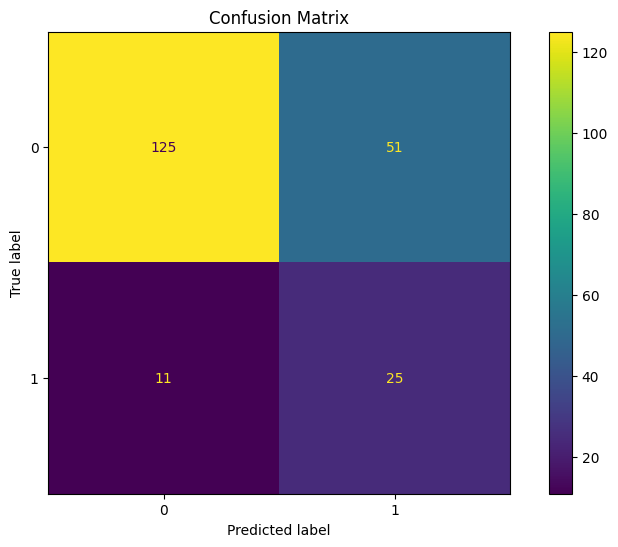

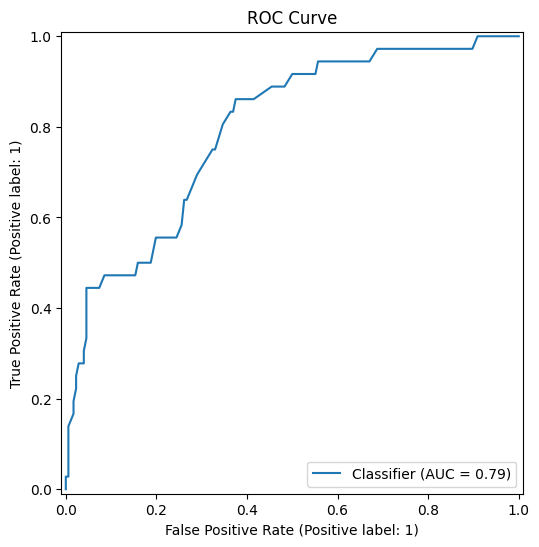

In [29]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_test_proba_rf)
plt.title("ROC Curve")
plt.show()

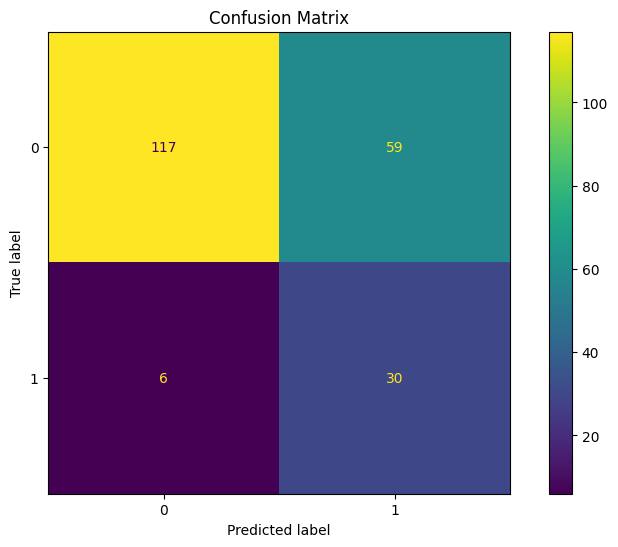

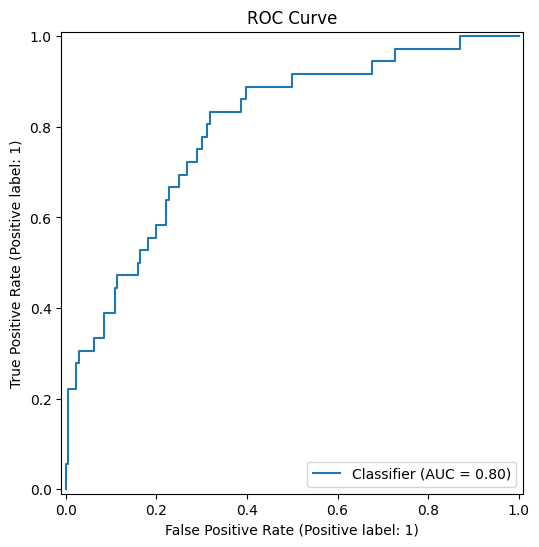

In [30]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_xgb)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_test_proba_xgb)
plt.title("ROC Curve")
plt.show()

**Insight** 
- XGBoost memiliki nilai True Positive lebih banyak
- XGBoost memili nilai False Negative lebih sedikit

### Simpan Model XGBoost

**Fit pipeline pada seluruh data training**

In [35]:
# Transform data full
X_train_full_prep = preprocessor.fit_transform(X_train_full)

# Resampling seluruh data dengan SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smoteenn.fit_resample(X_train_full_prep, y_train_full)

# Train model akhir dengan semua data
final_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=imbalance_ratio,
    eval_metric='logloss',
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1
)

final_model.fit(X_train_res, y_train_res)

# Buat pipeline akhir
full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', final_model)
])

**Simpan Model**

In [36]:
joblib.dump(full_pipeline, 'model_pipeline.pkl')
print("Model pipeline berhasil disimpan.")

Model pipeline berhasil disimpan.


### Fitur Important dari Model XGBoost


Top 10 Fitur Penting:
                              Feature  Importance
49                        OverTime_No    0.082151
15                   StockOptionLevel    0.078388
45       JobRole_Sales Representative    0.073944
37  JobRole_Healthcare Representative    0.072977
41     JobRole_Manufacturing Director    0.063481
42          JobRole_Research Director    0.056982
25       BusinessTravel_Travel_Rarely    0.028912
32             EducationField_Medical    0.026971
46             MaritalStatus_Divorced    0.026372
28                   Department_Sales    0.025901


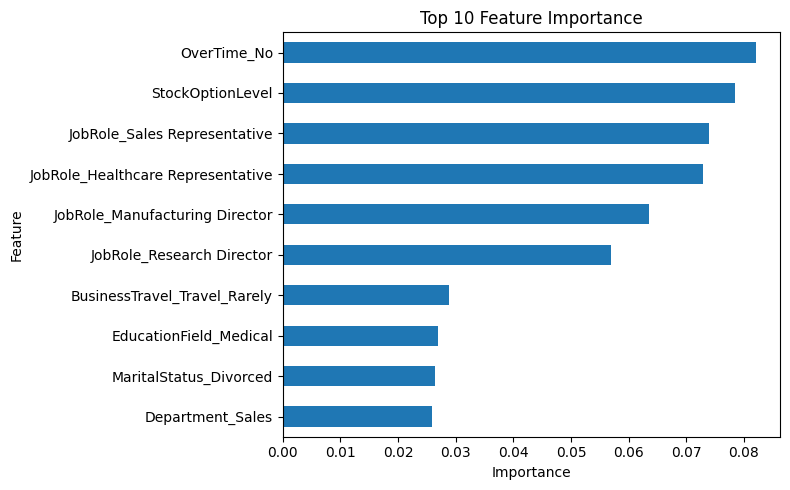

In [32]:
# Ambil nama fitur dari preprocessor
encoded_cat_cols = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_cols)

importances = final_model_xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Tampilkan top 10
print("\nTop 10 Fitur Penting:")
print(feature_importance_df.head(10))

# Visualisasi feature importance
feature_importance_df.head(10).plot.barh(x='Feature', y='Importance', figsize=(8, 5), title='Top 10 Feature Importance', legend=False)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Insight**

Berdasarkan hasil pemodelan menggunakan algoritma XGBoost dan analisis feature importance, model mengidentifikasi beberapa fitur yang paling berpengaruh terhadap keputusan karyawan untuk keluar dari perusahaan (attrition).